In [2]:
import pandas as pd
import plotly.graph_objects as go
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter
import plotly.express as px
import plotly.io as pio
pio.templates.default = "plotly_white"

In [3]:
df = pd.read_csv("chatgpt_reviews.csv")
df.head()

,Review Id,Review,Ratings,Review Date
0,6fb93778-651a-4ad1-b5ed-67dd0bd35aac,good,5,2024-08-23 19:30:05
1,81caeefd-3a28-4601-a898-72897ac906f5,good,5,2024-08-23 19:28:18
2,452af49e-1d8b-4b68-b1ac-a94c64cb1dd5,nice app,5,2024-08-23 19:22:59
3,372a4096-ee6a-4b94-b046-cef0b646c965,"nice, ig",5,2024-08-23 19:20:50
4,b0d66a4b-9bde-4b7c-8b11-66ed6ccdd7da,"this is a great app, the bot is so accurate to...",5,2024-08-23 19:20:39


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 196727 entries, 0 to 196726
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   Review Id    196727 non-null  object
 1   Review       196721 non-null  object
 2   Ratings      196727 non-null  int64 
 3   Review Date  196727 non-null  object
dtypes: int64(1), object(3)
memory usage: 6.0+ MB


In [5]:
df.isnull().sum()

Review Id      0
Review         6
Ratings        0
Review Date    0
dtype: int64

In [6]:
df['Review'] = df['Review'].astype(str).fillna('')

In [8]:
!pip install textblob

  Using cached textblob-0.19.0-py3-none-any.whl.metadata (4.4 kB)
Using cached textblob-0.19.0-py3-none-any.whl (624 kB)


In [9]:
from textblob import TextBlob

In [10]:
# function to determine sentiment polarity
def get_sentiment(review):
    sentiment = TextBlob(review).sentiment.polarity
    if sentiment > 0:
        return 'Positive'
    elif sentiment < 0:
        return 'Negative'
    else:
        return 'Neutral'

# apply sentiment analysis
df['Sentiment'] = df['Review'].apply(get_sentiment)

sentiment_distribution = df['Sentiment'].value_counts()

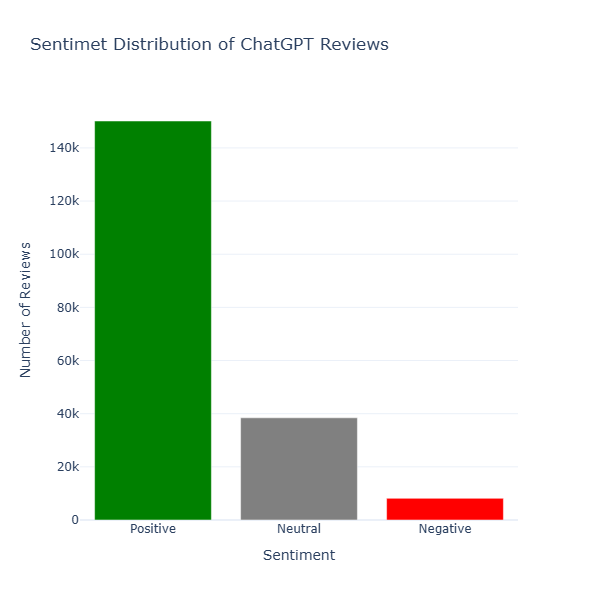

In [13]:
fig = go.Figure(data=[go.Bar(
    x = sentiment_distribution.index,
    y = sentiment_distribution.values,
    marker_color = ['green','grey','red'],
)])
fig.update_layout(
    title='Sentimet Distribution of ChatGPT Reviews',
    xaxis_title='Sentiment',
    yaxis_title='Number of Reviews',
    width=500,
    height=600
)
fig.show()

## Analyzing what Users like about ChatGPT

In [15]:
# filter reviews with positive sentiment
positive_reviews = df[df['Sentiment'] == 'Positive']['Review']

In [16]:
# use CountVectorizer to extract common phrases (n-grams)
vectorizer = CountVectorizer(ngram_range=(2,3), stop_words='english', max_features=100)
X = vectorizer.fit_transform(positive_reviews)

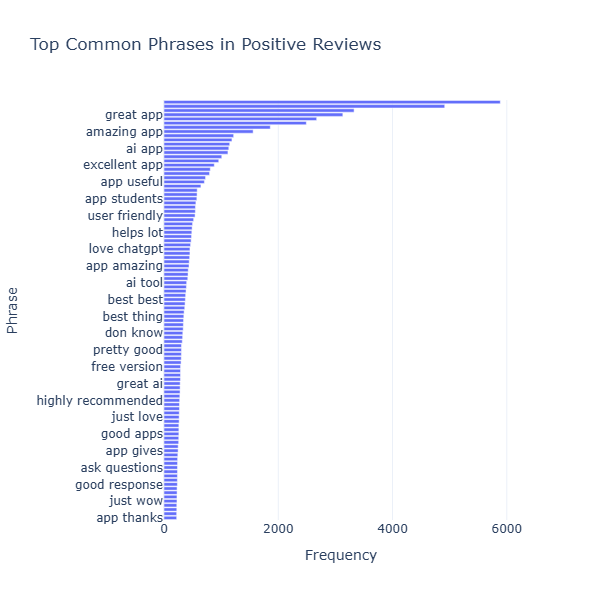

In [24]:
# sum the counts of each phrase
phrase_counts = X.sum(axis=0)
phrases = vectorizer.get_feature_names_out()
phrase_freq = [(phrases[i], phrase_counts[0, i]) for i in range(len(phrases))]

# sort phrases by frequency
phrase_freq = sorted(phrase_freq, key=lambda x: x[1], reverse=True)

phrase_df = pd.DataFrame(phrase_freq, columns=['Phrase', 'Frequency'])

fig = px.bar(phrase_df,
             x ='Frequency',
             y = 'Phrase',
             orientation ='h',
             title = 'Top Common Phrases in Positive Reviews',
             labels = {'Phrase': 'Phrase', 'Frequency': 'Frequency'},
             width = 700,
             height=600)
fig.update_layout(
    xaxis_title='Frequency',
    yaxis_title='Phrase',
    yaxis={'categoryorder':'total ascending'}
)
fig.show()
            

## Analyzing what users dont like about Chatgpt

In [33]:
#filter reviews with negative sentiments
negative_reviews = df[df['Sentiment'] == 'Negative']['Review']

#use Countvectorizer to extract common phrase(n-grams) for negative
X_neg = vectorizer.fit_transform(negative_reviews) 

#sum the counts of each phrase in negative reviews
phrase_counts_neg = X_neg.sum(axis=0)
phrases_neg = vectorizer.get_feature_names_out()
phrase_freq_neg = [(phrases_neg[i], phrase_counts_neg[0,i]) for i in range(len(phrases_neg))]

#sort phrases by frequency
phrase_freq_neg = sorted(phrase_freq_neg, key=lambda x: x[1],reverse=True)

phrase_neg_df = pd.DataFrame(phrase_freq_neg, columns=['Phrase' , 'Frequency'])

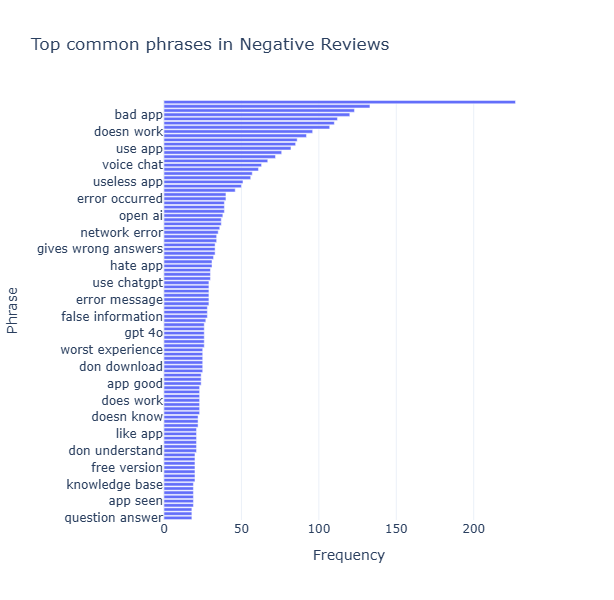

In [38]:
fig = px.bar(phrase_neg_df,
             x='Frequency',
             y='Phrase',
             orientation='h',
             title='Top common phrases in Negative Reviews',
             labels={'Phrase':'Phrase', 'Frequency':'Frequency'},
             width=800,
             height=600)
fig.update_layout(
    xaxis_title = 'Frequency',
    yaxis_title = 'Phrase',
    yaxis={'categoryorder':'total ascending'}
)
fig.show()

## common problems faced by users in chatgpt
To analyze common problems people face with ChatGPT, I’ll focus on the frequent phrases and keywords found in the negative reviews. I’ll categorize these phrases into broader problem areas, and then visualize the most common issues.

In [42]:
#grouping similar phrases into broader problem categories 
problem_keywords = {
    'Incorrect Answers' : ['wrong answer', 'gives wrong', 'incorrect', 'inaccurate', 'wrong'],
    'App Performance' : ['slow', 'lag', 'crash', 'bug', 'freeze', 'loading', 'glitch', 'worst app', 'bad app', 'horrible', 'terrible'],
    'User Interace': ['interface', 'UI','difficult to use', 'confusing','layout'],
    'Features Missing/Not Working':['feature missing','not working','missing','broken','not available'],
    'Quality of Response':['bad response', 'useless','poor quality','irrelevant','nonsense']
}

#initalize a dict to count problems
problem_count = {key: 0 for key in problem_keywords.keys()}

#count occurences of problem-related phrases n negative reviews
for phrase, count in phrase_freq_neg:
    for problem, keywords in problem_keywords.items():
        if any(keyword in phrase for keyword in keywords):
            problem_count[problem] += count
            break

problem_df = pd.DataFrame(list(problem_count.items()), columns=['Problem', 'Frequency'])

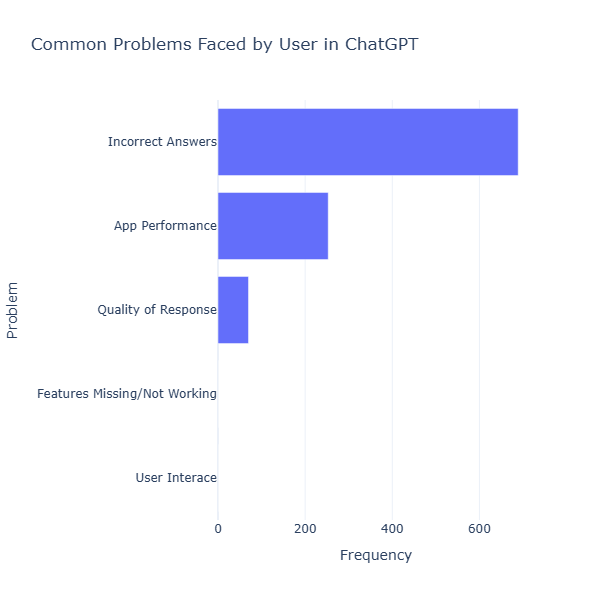

In [43]:
fig = px.bar(problem_df,
             x = 'Frequency',
             y = 'Problem',
             orientation = 'h',
             title = 'Common Problems Faced by User in ChatGPT',
             labels ={'Problem':'Problem', 'Frequency':'Frequency'},
             width = 800,
             height = 600)
fig.update_layout(
    plot_bgcolor='white',
    paper_bgcolor='white',
    xaxis_title='Frequency',
    yaxis_title='Problem',
    yaxis={'categoryorder':'total ascending'}
)
fig.show()

Analyzing how Reviews Changed over time

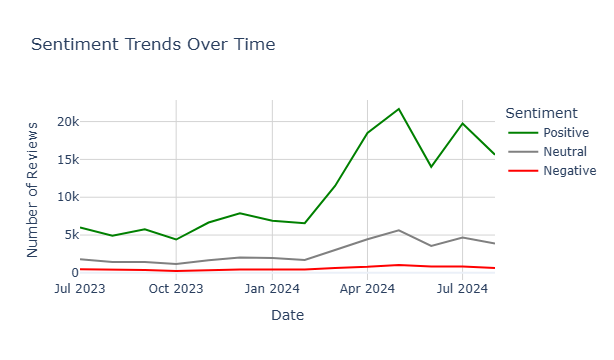

In [46]:
#1 Aggregate the review by their sentiment(+ve,-ve,neutral)overtime
#2 Visualize the trends in the volume of each sentiment type over time

# convert Review Date to datetime format
df['Review Date']=pd.to_datetime(df['Review Date'])

#aggregate sentiment counts by date
sentiment_over_time = df.groupby([df['Review Date'].dt.to_period('M'), 'Sentiment']).size().unstack(fill_value=0)

#convert the period back to datetime for plotting
sentiment_over_time.index = sentiment_over_time.index.to_timestamp()

fig = go.Figure()

fig.add_trace(go.Scatter(x=sentiment_over_time.index, y=sentiment_over_time['Positive'],
                         mode='lines', name='Positive', line=dict(color='green')))
fig.add_trace(go.Scatter(x=sentiment_over_time.index, y=sentiment_over_time['Neutral'],
                         mode='lines', name='Neutral', line=dict(color='grey')))
fig.add_trace(go.Scatter(x=sentiment_over_time.index, y=sentiment_over_time['Negative'],
                         mode='lines', name='Negative', line=dict(color='red')))

fig.update_layout(
    title='Sentiment Trends Over Time',
    xaxis_title='Date',
    yaxis_title='Number of Reviews',
    plot_bgcolor='white',
    paper_bgcolor='white',
    legend_title_text='Sentiment',
    xaxis=dict(showgrid=True, gridcolor='lightgrey'),
    yaxis=dict(showgrid=True, gridcolor='lightgrey')
)
fig.show()

## Analyzing how often Users Promote Chatgpt

In [50]:
# define the category based on the ratings
df['NPS Category'] = df['Ratings'].apply(lambda x: 'Promoter' if x == 5 else ('Passive' if x == 4 else 'Detractor'))

#calculate the percentage of each category
nps_counts = df['NPS Category'].value_counts(normalize=True)*100

#calculate NPS
nps_score = nps_counts.get('Promoter',0) - nps_counts.get('Detractor',0)

#display the Nps score
nps_score

64.35313912172705